
### В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.


In [3]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np


In [93]:
classification_data, classification_labels = datasets.make_classification(n_features = 8, n_informative = 3, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=7)

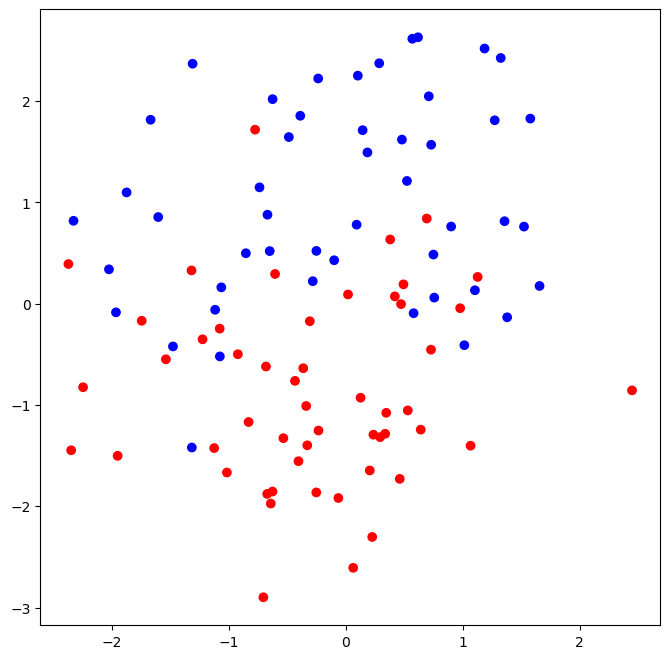

In [94]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [95]:
# узел где принмается решение о разбиении данных
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        


# Лист фин эл дерева содержит метку класа
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [126]:
# Функция выбора критерия загрязнености данных

def functional_of_quality(labels, criterion):

    labels = list(labels) # отсюда можно посчитать общее количесво встречаемой метки
    set_labels = set(labels) # метки без повторов что бы не проходится несколько раз по одной и той же метке
    
    entropy = 0
    impurity = 1
    for label in set_labels: #расматриваем каждую метку по отдельности
        p = labels.count(label) / len(labels) # сумма обьектов принадлежащих к 1 метки / общее число обьектов
        entropy -= p * np.log2(p)
        impurity -= p ** 2
    if  criterion == 'gini':  
        return impurity
    elif criterion == 'entropy':  
        return  entropy
    elif criterion == 'MSE': 
        return  np.mean((labels - np.mean(labels))**2) 
    else:
        return 'Не существующий критерий'

# расчт качества текущего узла (критерий на текущем уровне дерева)
def quality(left_labels, right_labels, current_quality, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0]))
    
    return current_quality - p * functional_of_quality(left_labels, criterion) - (1 - p) * functional_of_quality(right_labels, criterion)



In [97]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion='gini',  min_leaf = 1):
    
    #  обозначим минимальное количество объектов в узле
   
    current_criterion = functional_of_quality(labels, criterion)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features): # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


In [98]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion='gini', deep_tree = 5, count = 0):
    
    quality, t, index = find_best_split(data, labels, criterion, min_leaf=8)
   
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    # в бинарном дереве нет смысла считать листья так как количество листьев будет 2**n, где n - глубина дерева
    # соответственно мы можем ограничить глубину:
    if count >= deep_tree:
        return Leaf(data, labels)
    
        
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # инкрементируем счетчик глубины дерева
    count += 1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criterion=criterion, deep_tree = deep_tree, count=count)
    false_branch = build_tree(false_data, false_labels, criterion=criterion, deep_tree = deep_tree, count=count)
    
   
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [99]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [100]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


In [101]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")


In [102]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)
def computing(criterion='gini', deep_tree = 3):
    # Построим дерево по обучающей выборке
    my_tree = build_tree(train_data, train_labels, criterion = criterion, deep_tree = deep_tree)
    # Напечатаем ход нашего дерева
    print_tree(my_tree)
    # Получим ответы для обучающей выборки 
    train_answers = predict(train_data, my_tree)
    # И получим ответы для тестовой выборки
    answers = predict(test_data, my_tree)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность на обучающей выборке: {train_accuracy}')
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, answers)
    print(f'Точность на обучающей выборке: {test_accuracy}')
    
computing(criterion='gini', deep_tree = 3) # jini

Индекс 1
Порог 0.3912170332020768
--> True:
  Индекс 5
  Порог 0.4297593522981016
  --> True:
    Индекс 5
    Порог -0.9633004516224544
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 1
--> False:
  Индекс 0
  Порог 0.28619765758107774
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1
Точность на обучающей выборке: 92.85714285714286
Точность на обучающей выборке: 76.66666666666667


In [103]:
computing(criterion='entropy', deep_tree = 3) # entropy

Индекс 1
Порог 0.3912170332020768
--> True:
  Индекс 5
  Порог 0.10583993972006955
  --> True:
    Индекс 0
    Порог 0.46174683535015315
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 1
--> False:
  Индекс 0
  Порог 0.28619765758107774
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1
Точность на обучающей выборке: 91.42857142857143
Точность на обучающей выборке: 76.66666666666667


### Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

Комментарий:
Критерий останова "глубина дерева" я реализовал не в коде из методички, а уже в измененном коде для задачи регрессии. На суть это не влияет, поскольку функция build_tree не зависит от особенностей решаемой задачи (она просто строит дерево и ничего не знает о контексте).

In [117]:
# класс листа для задачи регрессии

class LeafRegration:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)        
        return prediction  

In [118]:
def build_tree_regration(data, labels, criterion = 'MSE', deep_tree=8):
    
    quality, t, index = find_best_split(data, labels, criterion)
    count = 0
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return LeafRegration(data, labels)
    
    # в бинарном дереве нет смысла считать листья так как количество листьев будет 2**n, где n - глубина дерева
    # соответственно мы можем ограничить глубину:
    if count >= deep_tree:
        return LeafRegration(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # инкрементируем счетчик глубины дерева
    count += 1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,  criterion = criterion, deep_tree = deep_tree, count=count)
    false_branch = build_tree(false_data, false_labels, criterion = criterion, deep_tree = deep_tree, count=count)
    
   
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [119]:

X, y = datasets.make_regression(n_samples=900, n_features=9, random_state=14)

# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.3, random_state=5)

In [123]:

from sklearn.metrics import r2_score

In [124]:
def computing(criterion = 'MSE', deep_tree = 3):
    # Построим дерево по обучающей выборке
    my_tree = build_tree_regration(X_train, y_train, criterion = criterion, deep_tree = deep_tree)
    # ход  дерева
    print_tree(my_tree)
    # Получим ответы для обучающей выборки 
    train_answers = predict(X_train, my_tree)
    # И получим ответы для тестовой выборки
    answers = predict(X_test, my_tree)
    R2_train = r2_score(y_train, train_answers)
    print(f'Коэфицент детерминации на обучающей выборке: {R2_train}')
    R2_test = r2_score(y_test, answers)
    print(f'Коэфицент детерминации на тестовой выборке: {R2_test}')

In [125]:
computing()

Индекс 5
Порог 0.33552576605946877
--> True:
  Индекс 4
  Порог -0.14819177688170343
  --> True:
    Индекс 7
    Порог 0.5215175126146055
    --> True:
      Прогноз: -167.929422737981
    --> False:
      Прогноз: -67.46100129150778
  --> False:
    Индекс 7
    Порог 0.6803225714811503
    --> True:
      Прогноз: -18.87586618795828
    --> False:
      Прогноз: 167.39405414956877
--> False:
  Индекс 2
  Порог 0.11233815346001054
  --> True:
    Индекс 4
    Порог -0.42773059347624787
    --> True:
      Прогноз: 123.67848274150819
    --> False:
      Прогноз: -23.011602522065886
  --> False:
    Индекс 4
    Порог 0.2879995637896426
    --> True:
      Прогноз: 28.399417967831482
    --> False:
      Прогноз: 277.0646174788285
Коэфицент детерминации на обучающей выборке: 0.35437890147734097
Коэфицент детерминации на тестовой выборке: 0.23262725485736047
